<center><h1>DATAJAM.AI MNIST - <a style="color:pink">PRO VERSION</a> -</h1></center>

<img src="https://i.ibb.co/zJyLQ0s/Screen-Shot-2019-07-20-at-22-42-19.png" style="width:300px">

# 1) Please never forget this MEME

<img src="https://image-store.slidesharecdn.com/65407daf-f05b-4fa2-8590-4e964b0bfd58-large.jpeg" style="width:400px"></img>

# 2) Data preparation

## a) tidy up the folders

In [39]:
import os
import shutil
import glob2
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [40]:
cd /Users/assansanogo/Downloads/DATAJAM_RESSOURCES

/Users/assansanogo/Downloads/DATAJAM_RESSOURCES


In [41]:
CATEGORIES = ["dog","cat"]
TRAIN_PATH="./train"
OUTPUT_PATH_TRAIN="./training_set"
OUTPUT_PATH_VAL="./validation_set"
COLUMNS= ["file_path","category"]
BATCH_SIZE=32

In [42]:
# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [43]:
# we limit the experiment to a few data points
limits = 1000
(x_train, y_train), (x_test, y_test) = (x_train[:limits], y_train[:limits]), (x_test[:limits], y_test[:limits])

In [44]:
# gives us information on the number of classes predicted
categories =  np.unique(y_train).size

In [45]:
# ratio of data used for training 
ratio = 0.8

In [46]:
def represent_picture(x,y):
    an_im = plt.imshow(x, cmap='gray')
    plt.title(y)
    plt.show()
    return(x)

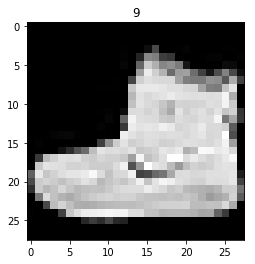

In [47]:
# just visual check of the image
# the image is 28*28
# the image # of channels is 1
image_to_check = represent_picture(x_train[0],y_train[0])

In [48]:
# the image is 28*28 and has 1 channel.
# typical RGB images have a shape (a,b,c)
# typical grayscale images have a shape (a,b)
# w emust be careful when feeding these images to CNN. some reformating is often needed.

# therefore we must adapt these images to the input layer of the given model we want to load
# each model has a particular input shape. in the case of VGG it's (224,224,3)
print(x_train[0].shape)

(28, 28)


In [49]:
def resize_me(x,size=(224,224),mode=cv2.INTER_CUBIC):
    # resize the image to the network input shape
    res= cv2.resize(x,(224,224),mode)
    return(cv2.merge([res,res,res]))


In [50]:
# we loop through all the images
# resize the image with the function defined above
# save the numpy array "of the list"

l=[]
for el in tqdm(x_train):
    l.append(resize_me(el,size=(224,224),mode=cv2.INTER_CUBIC))
x_train_new = np.array(l)

100%|██████████| 1000/1000 [00:00<00:00, 7620.20it/s]


In [51]:
# it is a good practice to check the images after any transformation
# the upsampling of the image is altering the image (blur)

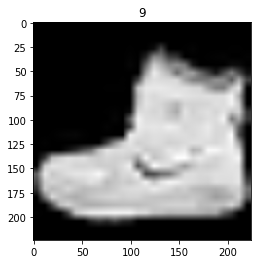

In [52]:
image_to_check_resized = represent_picture(x_train_new[0],y_train[0])

In [53]:
# make a generator from list of images and label

In [54]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator()

In [55]:
train_data, train_labels= x_train_new[:int(ratio*x_train.shape[0])],y_train[:int(ratio*x_train.shape[0])]
val_data, val_labels= x_train_new[int(ratio*x_train.shape[0]):],y_train[int(ratio*x_train.shape[0]):]


In [56]:
print("there is  {0} training obs & labels ".format(train_labels.shape))

print("there is {0} validation obs & labels".format(val_labels.shape))


there is  (800,) training obs & labels 
there is (200,) validation obs & labels


# 3) Model construction (model created from scratch)

In [113]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications import VGG16

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.compat.v1.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model


from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

In [114]:
# a CNN architecture based on VGG16
def get_my_model(categories=10, size=(224,224,3)):


    # load the VGG16 network, ensuring the head FC layer sets are left
    # off
    try:
        baseModel = VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=size))
    except:
                baseModel = VGG16(weights="imagenet", include_top=False)

    # construct the head of the model that will be placed on top of the
    # the base model
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(categories, activation="softmax")(headModel)

    # place the head FC model on top of the base model (this will become
    # the actual model we will train)
    model = Model(inputs=baseModel.input, outputs=headModel)
    return model


In [115]:
#save the model in a variable
fashion_mnist_1 = get_my_model(categories=10, size=(224,224,3))

In [116]:
# get the structure of the model
fashion_mnist_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

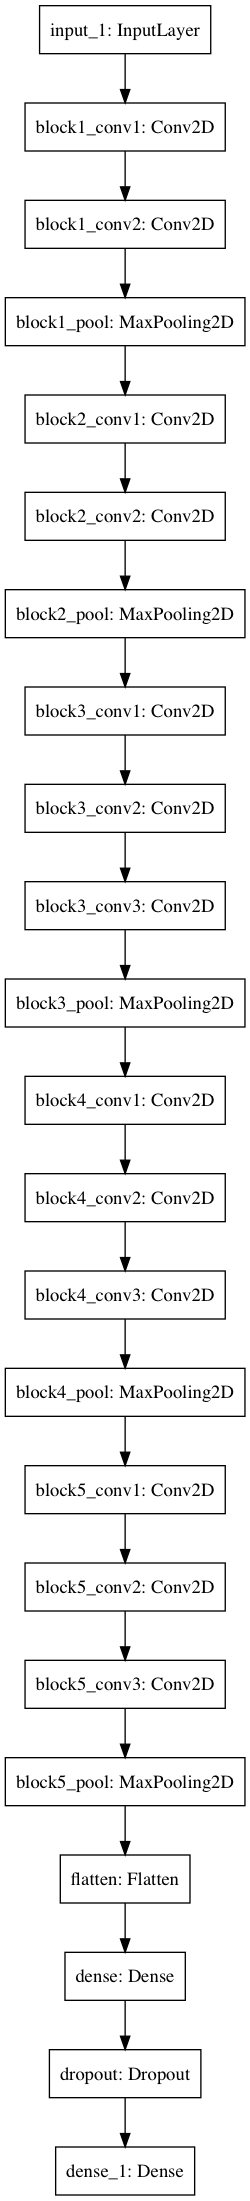

In [117]:
#save the model
plot_model(fashion_mnist_1, to_file='./fashion_MNIST_model.png')

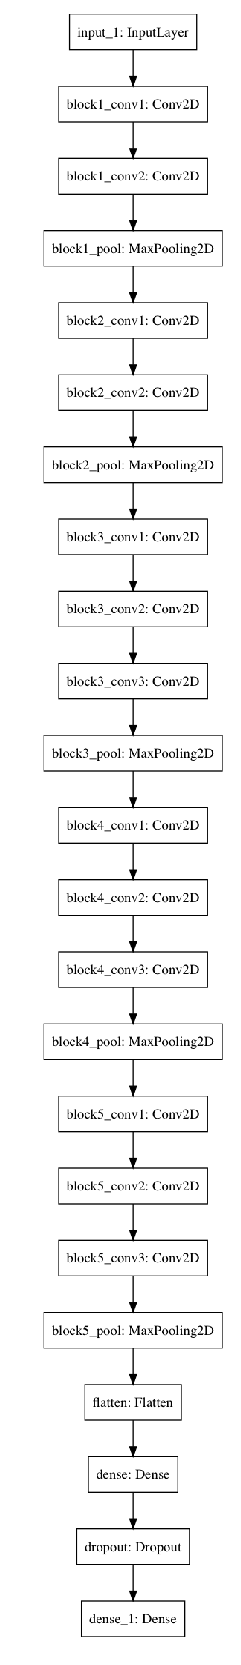

In [119]:
comp_im = plt.imread('./fashion_MNIST_model.png')
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(comp_im)
plt.show()

# 4) The callbacks

In [120]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [121]:
weights_path ="./weights"

if os.path.exists(weights_path)==False:
    os.mkdir(weights_path)

In [122]:
# checkpoints
# various settings can be used to save weights


filepath="./weights/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint_max = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint_all = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False)


In [123]:
# tensorboard
# various settings can be chosen


tbCallBack  = TensorBoard(log_dir='./Graph', histogram_freq=0,write_graph=True, write_images=True)

In [124]:
callbacks_list = [checkpoint_max, tbCallBack]

# 5) The training

In [125]:
# start the training: 
# the model will fit the training generator
# the model will be evaluated at each epoch on the validation set

In [126]:
# list all layers except the 4 last layers
fashion_mnist_1.layers[:-4]

In [127]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in fashion_mnist_1.layers[:-4]:
	layer.trainable = False

<img src="https://i.imgur.com/mtimFxh.png" style="width:400px"></img>

In [128]:
# problem with 2 classes 
# we are following the validation accuracy
# in this case we use the sparse categorical crossentropy because we did not chnage our labels to 1 hot encoding
fashion_mnist_1.compile(loss='sparse_categorical_crossentropy',
          optimizer='sgd',
          metrics=['sparse_categorical_accuracy'])

In [129]:
# the model will be trained with SGD (stochastic gradient descent)

In [130]:
# the model is made to converge thanks to the backpropagation.
# the weights and other calculations are organized as a graph in keras/tensorflow

<img src="https://www.researchgate.net/profile/Gustav_Von_Zitzewitz/publication/331839269/figure/download/fig2/AS:737796776009728@1552915867134/The-computational-graph-of-a-simplified-four-nodes-back-propagation-adapted-from-11.png" style="with:50px"></img>

In [131]:
from keras.preprocessing.image import ImageDataGenerator
data_gen = ImageDataGenerator()

In [132]:
trainGen = data_gen.flow(train_data, train_labels, batch_size=32)

In [133]:
valGen = data_gen.flow(val_data, val_labels, batch_size=32)

In [ ]:
fashion_mnist_1.fit_generator(
        trainGen, #training set generator
        epochs=1,  #number of epochs
        validation_data=valGen,
        callbacks=callbacks_list,#list of callbacks (checkpoint & tensorboard)
        use_multiprocessing=True,
        workers=6,validation_steps=10,
        steps_per_epoch=1) 

#save weights
fashion_mnist_1.save_weights('frozen_body_head_train.h5')

In [ ]:
#load intermediate weights
# this can be useful when the notebook crashes

fashion_mnist_1.load_weights('frozen_body_head_train.h5')

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in fashion_mnist_1.layers:
	layer.trainable = True

In [ ]:
# reset our data generators
trainGen.reset()
valGen.reset()

In [ ]:
fashion_mnist_1.fit_generator(
        data_gen.flow(train_data, train_labels, batch_size=32), #training set generator
        epochs=1,  #number of epochs
        validation_data=data_gen.flow(val_data, val_labels, batch_size=32),
        callbacks=callbacks_list,#list of callbacks (checkpoint & tensorboard)
        use_multiprocessing=True,
        workers=6,
        validation_steps=10,
        steps_per_epoch=1) 

#save weights
fashion_mnist_1.save_weights('full_train.h5')

In [134]:
import kerastuner
from kerastuner import HyperModel

In [135]:
from kerastuner import tuners, HyperParameters
from kerastuner.tuners import Hyperband, RandomSearch


In [136]:
hp = HyperParameters()

In [137]:
hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])

0.01

In [138]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [139]:
categories=10
size=(224,224,3)

baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=size))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(units=hp.Range('units',
                                 min_value=32,
                                 max_value=512,
                                 step=32), 
                  activation="relu")(headModel)

headModel = Dropout(hp.Choice('dropout', 
                            values=[0.1,0.2,0.3,0.4,0.5]))(headModel)
headModel = Dense(categories, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in model.layers:
	layer.trainable = True

In [157]:
model2 = Sequential()
model2.add(Conv2D(32, (5, 5), padding='same',input_shape=(224,224,3),activation="relu"))
model2.add(Flatten())
model2.add(Dropout(hp.Choice('dropout', 
                            values=[0.1,0.2,0.3,0.4,0.5])))
model2.add(Dense(10, activation="softmax"))


In [179]:

model2 = Sequential()
model2.add(Conv2D(32, (5, 5), padding='same',input_shape=(224,224,3),activation="relu"))
model2.add(Flatten())
model2.add(Dense(10, activation="softmax"))

In [180]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
flatten (Flatten)            (None, 1605632)           0         
_________________________________________________________________
dense (Dense)                (None, 10)                16056330  
Total params: 16,058,762
Trainable params: 16,058,762
Non-trainable params: 0
_________________________________________________________________


In [181]:
class MyHyperModel(HyperModel):

    def __init__(self, num_classes,keras_model):
        self.num_classes = num_classes
        self.imported_model = keras_model

    def build(self, hp):       
        self.imported_model.compile(
            optimizer=tensorflow.keras.optimizers.Adam(
                hp.Choice('learning_rate',
                          values=[1e-2, 1e-3, 1e-4])),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        return self.imported_model


In [182]:
hypermodel = MyHyperModel(num_classes=10, keras_model=model2)

In [185]:
tuner = RandomSearch(hypermodel, 
                     objective='accuracy',
                    max_trials=10,
                    directory='my_dir',
                    project_name='helloworld')

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-181-49c3fd2285ba>", line 13, in build
    metrics=['accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
  File "/Users/assan

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-181-49c3fd2285ba>", line 13, in build
    metrics=['accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
  File "/Users/assan

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-181-49c3fd2285ba>", line 13, in build
    metrics=['accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
  File "/Users/assan

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-181-49c3fd2285ba>", line 13, in build
    metrics=['accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
  File "/Users/assan

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-181-49c3fd2285ba>", line 13, in build
    metrics=['accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
  File "/Users/assan

RuntimeError: Too many failed attempts to build model.

In [111]:
tuner.search(train_data, train_labels,
             epochs=20,
             validation_data=(val_data, val_labels))

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-106-f7f5da32870e>", line 13, in build
    metrics=['sparse_categorical_accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
 

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-106-f7f5da32870e>", line 13, in build
    metrics=['sparse_categorical_accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
 

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-106-f7f5da32870e>", line 13, in build
    metrics=['sparse_categorical_accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
 

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-106-f7f5da32870e>", line 13, in build
    metrics=['sparse_categorical_accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
 

Traceback (most recent call last):
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/kerastuner/engine/tuner.py", line 577, in _build_model
    model = self.hypermodel.build(hp)
  File "<ipython-input-106-f7f5da32870e>", line 13, in build
    metrics=['sparse_categorical_accuracy'])
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/training/tracking/base.py", line 458, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 330, in compile
    masks=self._prepare_output_masks())
  File "/Users/assansanogo/Desktop/PYTHON_ANACONDA/anaconda2/envs/neuromorphics/lib/python3.5/site-packages/tensorflow/python/keras/engine/training.py", line 1925, in _handle_metrics
    target, output, output_mask))
 

RuntimeError: Too many failed attempts to build model.